# AirBnB San Francisco Data

*** Abiram Sritharan, Anmol Jadvani, Vineet Shah ***

### Introduction

For our final tutorial, we chose to analyze data on Airbnb listings in San Francisco. We analyze how various factors, such as number of bedrooms, size of the listing, etc. affect pricing. 

We will walk you through how we organized our data and then the specific analytics we ran on the data set.

## 0. Setup

This project requires Python 3 and the following libraries:

```
pandas
numpy
matplotlib
scikit-learn
folium
statsmodels
ggplot
```

You can install these packages easily with the command:  `pip3 install <package_name>`

In [43]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import sklearn
import sklearn.metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import xml.etree.ElementTree as ET
import seaborn as sns

from ggplot import *

import scipy
from scipy import stats, optimize
from scipy.optimize import leastsq

import folium
from folium import plugins

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

### 1. Dataset

We got our dataset from http://insideairbnb.com/get-the-data.html. This website contains the data for AirBnB listings, split by city. Recently, we were looking at AirBnBs in San Francisco for a place to stay while interning this summer, so we figured it was fitting for us to analyze the AirBnB listings for specifically houses in that general area.

The data comes as 3 CSV files: 
    
    calendar.csv :  Contains price data for each listing
    listings.csv :  Contains most of the information for the listing (price, house attributes, etc.)
    reviews.csv  :  Contains the user reviews for each listing

Most of our analysis comes from `listings.csv`


### 2. Modifying Data

Most of the data was already tidy when we got it, so the only thing we had to do was modify the data into a usable format.

We did this when analyzing our data by making subsets of the original data and then formatting it. Our formatting included dropping NaN values from the dataframe as well as converting the prices from the string format to a float.

In [2]:
calendar = pd.read_csv('calendar.csv')
calendar.head()

,listing_id,date,available,price
0,10988680,2018-04-01,f,NaN
1,10988680,2018-03-31,f,NaN
2,10988680,2018-03-30,f,NaN
3,10988680,2018-03-29,f,NaN
4,10988680,2018-03-28,f,NaN


For each listing, this frame contains data on the available space, including, but not limited to, price, size in square feet, number of bedrooms, ratings, and so on.

In [3]:
listings = pd.read_csv('listings.csv')
listings = listings.rename(columns={"id": "listing_id"})
listings.head()

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,10988680,https://www.airbnb.com/rooms/10988680,20170401232214,2017-04-02,"Simple, new, clean accommodation",I signed a new lease and moving out of my plac...,"This is clean, simple, affordable accommodatio...",I signed a new lease and moving out of my plac...,none,Place is very conveniently located in the Miss...,...,10.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,0.07
1,8053481,https://www.airbnb.com/rooms/8053481,20170401232214,2017-04-02,Spacious 2BR/2BATH w/Shared Kitchen,Enjoy the whole main floor of our sunny 2-leve...,"We love our big, bright home and we know you w...",Enjoy the whole main floor of our sunny 2-leve...,none,Our Mission District neighborhood is among the...,...,9.0,f,NaN,SAN FRANCISCO,f,strict,f,f,1,0.49
2,14011173,https://www.airbnb.com/rooms/14011173,20170401232214,2017-04-02,Private room - Victorian House in the Mission,Awesome location in the Mission District of SF...,NaN,Awesome location in the Mission District of SF...,none,NaN,...,9.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,3,0.27
3,16142131,https://www.airbnb.com/rooms/16142131,20170401232214,2017-04-02,Spacious 1BR in the Mission District,"Quiet 1 bedroom apartment, with a spacious, we...",NaN,"Quiet 1 bedroom apartment, with a spacious, we...",none,NaN,...,8.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,0.48
4,9080622,https://www.airbnb.com/rooms/9080622,20170401232214,2017-04-02,Edwardian flat in heart of Mission,Bedroom with queen bed available. The condo i...,NaN,Bedroom with queen bed available. The condo i...,none,NaN,...,NaN,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,NaN


In [4]:
reviews = pd.read_csv('reviews.csv', index_col=None)
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7025250,36355262,2015-06-27,49913,Sean,Kevin was quick to respond and very coordinati...
1,7025250,36495849,2015-06-28,17344420,Terry,"Kevin, my host, was not home but stayed in tou..."
2,7025250,40263555,2015-07-29,38552007,Jon,I have to say that after staying in 3 hotels i...
3,7025250,55069111,2015-11-27,30440816,Sean,Clean room. The room I stayed in had a privat...
4,7025250,55166030,2015-11-28,33218898,Gregg,Very relaxed and casual atmosphere. The space ...


### 3. Exploratory Data Analysis

We created small subsets of the data and looked for relationships among variables within this subset.

#### 3.1 Square Feet and Ratings

Our first data analysis is relating the square footage of the house being listed to the the rating that it got. From intuition we assumed that a higher square foot house would generally have a better rating. We simply created a scatter plot of Rating vs. Square Feet.

In [5]:
size_rating = listings[['square_feet', 'review_scores_rating']].dropna()

size_rating.head()

,square_feet,review_scores_rating
35,500.0,93.0
65,170.0,100.0
115,600.0,100.0
124,1100.0,95.0
132,950.0,98.0


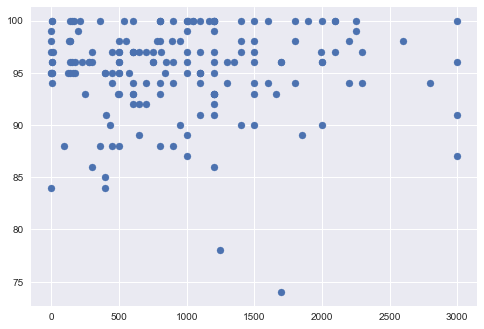

In [6]:
plt.scatter(size_rating['square_feet'], size_rating['review_scores_rating'])
plt.show()

Plot the avg ratings for each of the different sizes available.

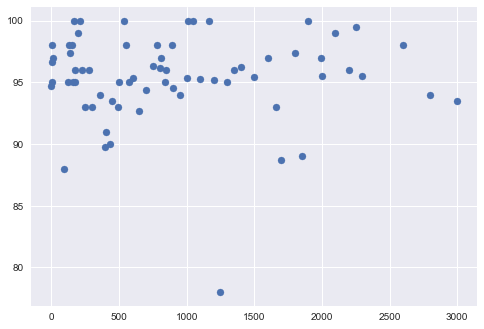

In [7]:
sizes = []
avg = []
for x in size_rating['square_feet'].unique():
    sizes.append(x)
    avg.append(size_rating[size_rating['square_feet'] == x]['review_scores_rating'].mean())

plt.scatter(sizes, avg)
plt.show()

From this graph, we can see that there is not much of a relationship between the size of the place that you are renting and how well the reviews they receive are. We have to look for correlations between other variables.

#### 3.2 Price and Ratings

Following our intuition from 3.1, we figured that there is likely a correlation between the price of a place and its rating. We figured that it's likely that a more expensive place will have better service and therefore be rated better as well.

In [67]:
price_ratings = listings[['price', 'review_scores_rating']].dropna()
print(price_ratings.shape)
price_ratings.head()

(6655, 2)


,price,review_scores_rating
0,$49.00,100.0
1,$220.00,96.0
2,$100.00,90.0
3,$117.00,100.0
5,$162.00,96.0


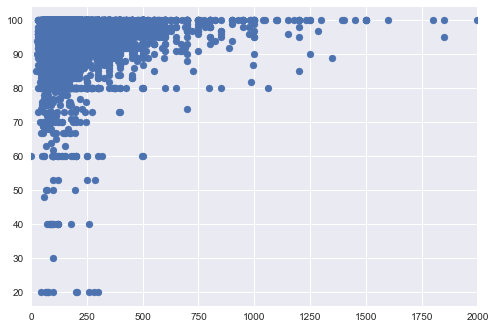

In [68]:
price_ratings['price'] = [float(x[1:].replace(',','')) for x in price_ratings['price']]
plt.scatter(price_ratings['price'], price_ratings['review_scores_rating'])
plt.xlim([0, 2000])
plt.show()

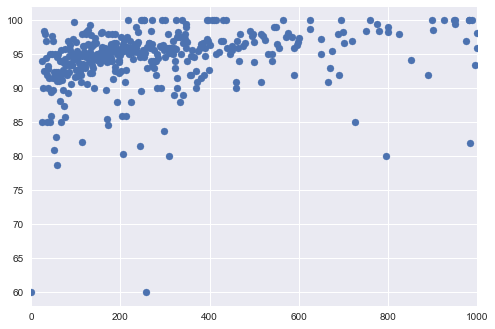

In [69]:
price = []
avg = []
for x in price_ratings['price'].unique():
    price.append(x)
    avg.append(price_ratings[price_ratings['price'] == x]['review_scores_rating'].mean())

plt.scatter(price, avg)
plt.xlim([0, 1000])
plt.show()

Interestingly, price seems to have very little effect on how well-rated a listing is. This means that when you are looking for a good quality place, just because one has a higher price than another does not mean that it is a safer bet (at least for AirBnBs in San Francisco).

#### 3.3 Price and Average Rating

Another relationship we thought would be interesting to analyze was price and average rating. We figured that having a higher price might indicate a listing having a higher rating as well. We followed a similar process to the past two steps and looked for correlation.

In [72]:
averages = listings[['neighbourhood_cleansed', 'price', 'review_scores_rating']].dropna()
averages['price'] = [float(x[1:].replace(',','')) for x in averages['price']]

neighbourhood = []
rating = []

for x in averages['neighbourhood_cleansed'].unique():
    neighbourhood.append(x)
    rating.append(averages[averages['neighbourhood_cleansed'] == x]['review_scores_rating'].mean()/10)
    
price = []

for x in averages['neighbourhood_cleansed'].unique():
    price.append(averages[averages['neighbourhood_cleansed'] == x]['price'].mean())

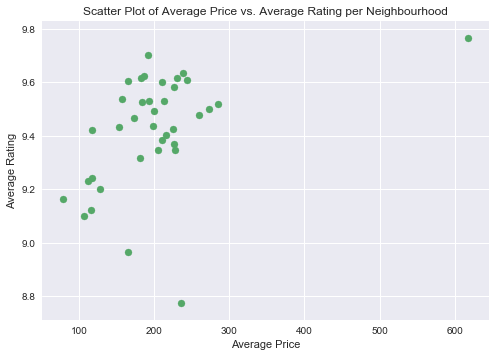

In [73]:
# We are creating a scatter plot of Average Price vs. Average Rating per Neighbourhood
plt.scatter(price, rating)

plt.xlabel('Average Price')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Average Price vs. Average Rating per Neighbourhood')
plt.show()

r value: 0.448748751248
p_value: 0.00533941328305
standard deviation: 0.000369236369353
slope: 0.00109690853756
intercept: 9.20133668451


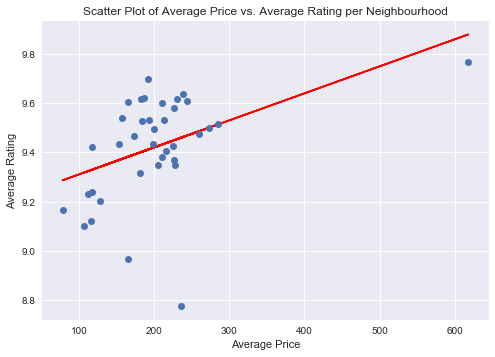

In [74]:
# We are then doing a linear regression through this scatter plot

slope, intercept, r_value, p_value, std_err = stats.linregress(price,rating)

print ('r value:', r_value)
print  ('p_value:', p_value)
print ('standard deviation:', std_err)
print ('slope:', slope)
print ('intercept:', intercept)

line = [slope * x + intercept for x in price]
plt.plot(price,line,'r-',price,rating,'o')
plt.xlabel('Average Price')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Average Price vs. Average Rating per Neighbourhood')
plt.show()

We can see that the data is not very well correlated, as we have an R value of 0.47, showing little to no relationship between average price and average rating. We will keep looking for data that has correlation.

#### 3.3 Bedrooms and Price

Next, we look at how the number of bedrooms provided would affect how expensive a particular location is. This is more of an obvious relationship, and we wanted to analyze it deeper so that we can measure the effect of bedrooms on price, so that later when we measure other factors on price, we can come up with a collection of factors affecting price and then follow through with more data analysis on all of these factors together.

In [18]:
bedroom_price = listings[['bedrooms', 'price']].dropna()
bedroom_price['price'] = [float(x[1:].replace(',','')) for x in bedroom_price['price']]
print(bedroom_price.shape)
bedroom_price.head()

(8698, 2)


,bedrooms,price
0,1.0,49.0
1,2.0,220.0
2,1.0,100.0
3,1.0,117.0
4,1.0,200.0


For this specific example, we found it best fitting to make a violin plot. We aim to show how listings tend to have similar prices when they have the same amount of bedrooms.

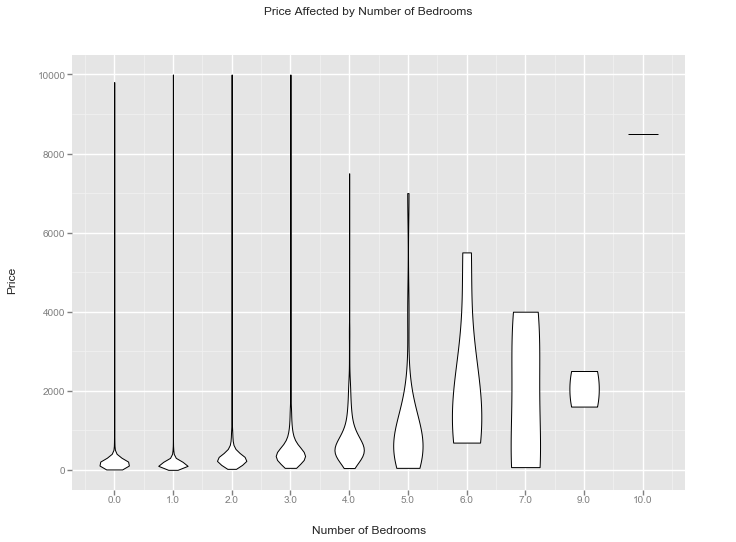

<ggplot: (-9223372036554971504)>

In [19]:
ggplot(aes(x='bedrooms', y='price'), data=bedroom_price) +\
    geom_violin() +\
    labs(title="Price Affected by Number of Bedrooms",
         x = "Number of Bedrooms",
         y = "Price")

As expected, we can see that houses tend to have a similar price when they have the same amount of bedrooms (other than a few outliers that are shown in the violin plot above). So there is clearly some sort of correlation between number of bedrooms and price. We will follow up with a regressionary model on the average price for each bedroom.

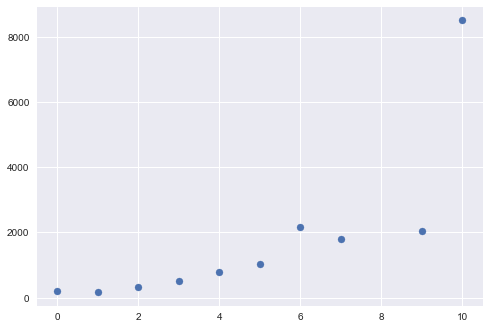

In [20]:
bedavg = []
numrooms = []
for x in bedroom_price['bedrooms'].unique():
    bedavg.append(bedroom_price[bedroom_price['bedrooms'] == x]['price'].mean())
    numrooms.append(x)
    
bedavg_mean = np.array(bedavg).mean()
plt.scatter(numrooms, bedavg)
plt.show()

By looking at the data, we can see a linear trend (other than an outlier in the top right), so we will follow with a linear regression model, after pruning outliers. We will remove any data that is more than 1.5 * IQR (Inter-quartile range) from the mean.

For a more in depth explanation of outlier removal, see: https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244

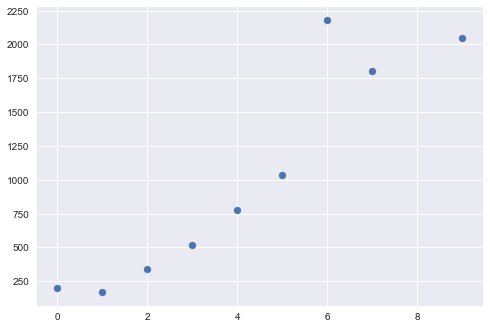

In [21]:
q75, q25 = np.percentile(bedavg, [75 ,25])
iqr = q75 - q25

bedavg = []
numrooms = []

for x in bedroom_price['bedrooms'].unique():
    bed_price_mean = bedroom_price[bedroom_price['bedrooms'] == x]['price'].mean()
    if bedavg_mean - 1.5 * iqr <= bed_price_mean <= bedavg_mean + 1.5 * iqr:
        bedavg.append(bed_price_mean)
        numrooms.append(x)

plt.scatter(numrooms, bedavg)
plt.show()

This is a simple definition of a function that takes a data set (of x and y values) and creates a polynomial fit of degree `deg`. This function plots the data alongside its polynomial fit as well as prints our the $r^2$ value of the fit. It uses Numpy's polyfit and Sklearn's metrics to make the fit and later get the $r^2$ value.

In [22]:
def fit_and_plot(XDat, YDat, deg):
    fit = np.polyfit(XDat, YDat, deg)
    poly = np.poly1d(fit)

    x = np.linspace(np.min(XDat), np.max(XDat), 40)
    y_pred = poly(x)
    x_pol = poly(XDat)
    plt.plot(x, y_pred, color='red')
    plt.scatter(XDat, YDat)
    plt.show()

    r2_score = sklearn.metrics.r2_score(YDat, x_pol)
    print('R^2 Value: ', r2_score)

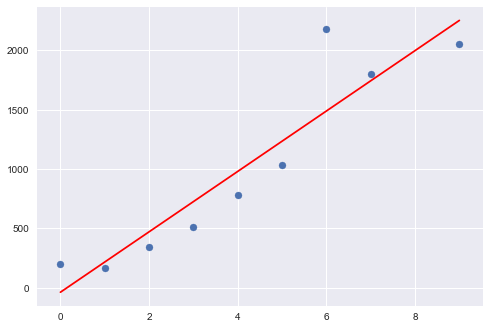

R^2 Value:  0.860623210425


In [23]:
fit_and_plot(numrooms, bedavg, 1)

After removing the outlier, we found the data did exhibit linear properties. We found a linear regression model for the data, and calculated the $r^2$ score. We found $r^2 = 0.86$, which is a relatively high value, indicating that our data does more or less have a linear correlation. Since we found this relationship, we will revisit the relation between number of bedrooms and price once we find another variable that has a relationship to price as well.

#### 3.4 Relationship Between Size and Price

Logically, it would make sense for a customer to pay more for a more spacious location. Here we explore the relationship between the amount of square feet rented and how it affects the price of the place.

In [24]:
size_price = listings[['square_feet', 'price']].dropna()
size_price['price'] = [float(x[1:].replace(',','')) for x in size_price['price']]
print(size_price.shape)
size_price.head()

(184, 2)


,square_feet,price
35,500.0,125.0
65,170.0,130.0
75,1100.0,450.0
94,1400.0,100.0
115,600.0,127.0


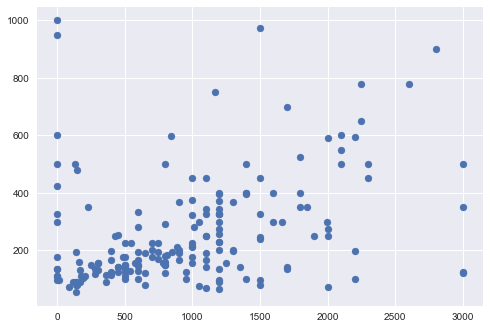

In [25]:
plt.scatter(size_price['square_feet'], size_price['price'])
plt.show()

As you can see from the graph above, there is surprisingly not much correlation between the size of the place that you are renting, and how expensive it is. To show this numerically, we tried to fit a regression line to the data above, and show the r^2 value. However, we can probably find some correlation after modifying the data a little bit.

First, we will remove unreasonable data (i.e. listings with square footage of less than 50).

Since it is very hard to make assumptions on all the data we figured that we should take a similar approach of getting the average price for each square footage. However, unlike bedroom count, square footage can vary a lot more, so we grouped up houses with close square footage. We did this by making intervals, of size 100, where each interval contained the data for houses with square footage within that interval. Next, we computed the average of the prices of all of these houses and mapped the midpoint of the interval to that average. The scatter plot below shows this data.

In [26]:
size_price = size_price[size_price['square_feet'] >= 50]

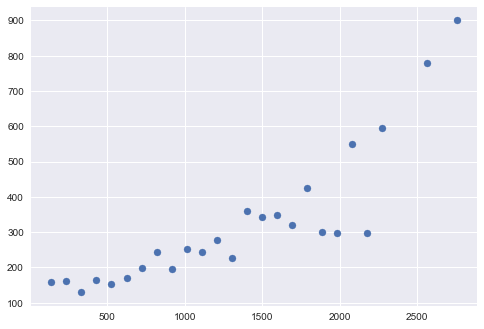

In [27]:
min_sz, max_sz = np.min(size_price['square_feet']), np.max(size_price['square_feet'])
min_sz, max_sz

num_intervals = 30
rng = (max_sz - min_sz) / num_intervals
avg = []
sze = []

for i in range(num_intervals):
    sze.append(((min_sz + i*rng) + (min_sz + (i+1)*rng)) / 2)
    group = size_price[size_price['square_feet'] >= min_sz + i*rng]
    group = group[group['square_feet'] < min_sz + (i+1)*rng]
    avg.append(group['price'].mean())
    
temp_sze = []
temp_avg = []

for i in range(len(sze)):
    if not np.isnan(avg[i]):
        temp_sze.append(sze[i])
        temp_avg.append(avg[i])

sze = temp_sze
avg = temp_avg

plt.scatter(sze, avg)
plt.show()

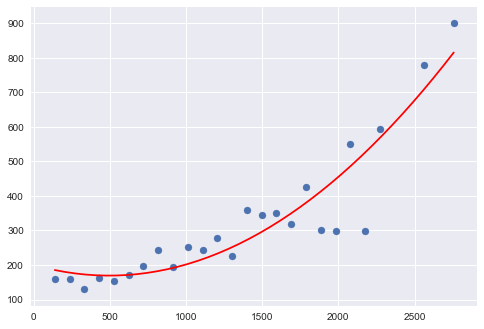

R^2 Value:  0.856183483639


In [28]:
fit_and_plot(sze, avg, 2)

Similar to before, we saw some correlation in the data and used our intuition to guess a good degree of polynomial fit. The data seemed to be quadratic, so we created a polynomial fit of degree 2. We saw a pretty good fit with this and also got a relatively good $r^2$ score of 0.86. This means our fit fit the data well and we can conclude that there is indeed some correlation between square footage and price of a place. 

### 4. Combined Regressionary Analysis

For this part, we wanted to improve our previous results of correlation. We found 2 different variables that affected the price of a place and we saw that we were able to give an ok prediction for price using each of these variables individually. The basis of this part is trying to use BOTH of those variables (number of bed rooms and size of listing) to create a good estimate on the price of a place. The main reason we are only using two variables is that it will be easy to visualize the prediction by using a 3D plot. 

Similar to before, we prepared our data in a way that made it easy to move forward. This included dropping the nan values and reformatting the prices into a float value. 

In [50]:
data = listings[['square_feet', 'bedrooms', 'price']].dropna()
data['price'] = np.array([float(x[1:].replace(',', '')) for x in data['price']])

The first thing we did was visualized the actual data. We created a 3D plot, plotting Price vs. Bedrooms vs. Square Feet.

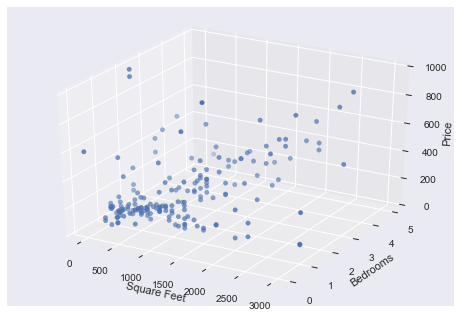

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 = data['square_feet']
x2 = data['bedrooms']
y = data['price']

ax.scatter(x1,x2,y)
ax.set_zlim([0, 1000])
ax.set_xlabel('Square Feet')
ax.set_ylabel('Bedrooms')
ax.set_zlabel('Price')

plt.show()

Now, we want to see if we can predict price using square feet and the number of bedrooms. As always we make sure our data is in a good format.

In [31]:
data = listings[['square_feet', 'bedrooms', 'price']].dropna()
data['price'] = np.array([float(x[1:].replace(',', '')) for x in data['price']])

We are going to make a few function definitions to help us with our calculations. Model returns all the values of our model. Residuals gives us the difference between the actual results and the modeled results. Predict will return a prediction using our model given an x and y value. The basic idea of creating a good model is reducing the total residuals. This is a machine learning algorithm in the background, which is taken care of by the library we are using.

In terms of the model we are using, we are combining the two correlations we found previously. We found earlier that there was a linear correlation between bedroom count and price and a quadratic correlation between square footage and bedroom. So, our model uses linear fitting with bedroom count and quadratic fitting with square footage and combines the two.

In [32]:
def model(p,x):
    a,b,c = p
    u = x[:,0]
    v = x[:,1]
    return (a*u**2 + b*v + c)

def residuals(p, y, x):
    a,b,c = p
    err = y - model(p,x)
    return err

def predict(p,x):
    return p[0]*x[0]**2 + p[1]*x[1] + p[2]

We start the algorithm by giving an initial guess of our coefficients, and the algorithm will reduce the total residuals so that we have an accurate fit. 

In [33]:
p0 = np.array([2,3,4]) #some initial guess
dependent = np.array(data['price'].tolist()) # y values we are trying to predict
coefficient = data[['square_feet', 'bedrooms']].as_matrix() # independent variables used as predictors

p = leastsq(residuals, p0, args=(dependent, coefficient))[0]

Once we have an accurate fit, given by the computer, we can create our graph of the prediction. Our prediction graph is going to be a curved plane, as seen below. This plane holds all the predicted prices given the number of bedrooms of a place and the square footage. 

The graph below shows the actual data (as points) and our prediction (as the plane). As I mentioned earlier, we were combining the linear and quadratic fitting to create this prediction. We can see that viewing it from the square foot axis shows a quadratic mapping while viewing it from the bedrooms axis shows more of a linear mapping. This is exactly what was planned as we wanted our prediction to account for both variables by using their individual correlation against price. 

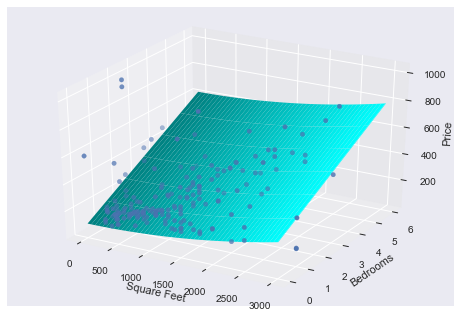

In [53]:
xx, yy = np.meshgrid(range(3001), range(7))

zz = p[0] * xx**2 + p[1] * yy + p[2]

plt3d = plt.figure().gca(projection='3d')
plt3d.scatter(data['square_feet'],data['bedrooms'],data['price'])
plt3d.set_xlabel('Square Feet')
plt3d.set_ylabel('Bedrooms')
plt3d.set_zlabel('Price')
plt3d.plot_surface(xx,yy,zz, color='cyan')
plt.show()

#### 4.1 Hypothesis Testing

We decided to run our hypothesis test on this data. Our end goal was to find more than one variable to predict prices very accurately. That being said, our hypothesis is that we CAN predict prices accurately given a listing's bedroom count and square footage (the null hypothesis being the negation of course). Clearly we made this hypothesis after cheating a little by seeing the correlation of price vs. bedroom count and price vs. square footage, and even a visual of our prediction. However, to verify our hypothesis (even though at this point it looks like we're right) we will follow with a statistical test.

There are several ways to verify a hypothesis, but in this case it is most applicable to just use the $r^2$ value. The $r^2$ value calculates the average of all the square differences between the actual data and our prediction. An $r^2$ value of closer to 1 is generally deemed as a statistically significant to be with a value of closer to 1. For the purpose of this we will do conduct our test at a 0.1 significance level (i.e. an $r^2$ value of at least 0.9 will be considered statistically significant). 

With that being said, we will continue by calculating the $r^2$ value. There are two ways to do so, and we will do both. To do both we need to make three calculations: SSR (Sum of Square Regression), SSE (Sum of Square Errors), and SSTO (Sum of Squares Total). The $r^2$ value is equivalent to the following:

$$ r^2 = \frac{SSR}{SSTO} = 1 - \frac{SSE}{SSTO} $$

The following are the equivalencies for SSR, SSE, and SSTO:

$$ SSR = \sum_{i=1}^n (\hat{y}_i - \bar{y})^2 $$
$$ SSE = \sum_{i=1}^n (y_i - \hat{y}_i)^2 $$
$$ SSTO = \sum{i=1}^n (y_i - \bar{y})^2 $$

Where:

$$ \hat{y}_i \text{ is our prediction} $$
$$ y_i \text{ is the actual value} $$
$$ \bar{y} \text{ is the mean of the actual values} $$

More about calculating $r^2$ can be found here: https://onlinecourses.science.psu.edu/stat501/node/255

In [35]:
prices = np.array(data['price'])
rooms = np.array(data['bedrooms'])
sze = np.array(data['square_feet'])
price_mean = sze.mean()

# Calcluating SSR
ssr = 0
for i in range(len(sze)):
    ssr += (predict(p, [sze[i], rooms[i]]) - price_mean)**2

# Calculating SSE
sse = 0
for i in range(len(sze)):
    sse += (predict(p, [sze[i], rooms[i]]) - prices[i])**2

#Calculating SSTO
ssto = 0
for i in range(len(sze)):
    ssto += (prices[i] - price_mean)**2

print('R2 using SSR: ', ssr/ssto)
print('R2 using SSE: ', 1-sse/ssto)

R2 using SSR:  0.956721623086
R2 using SSE:  0.956721622798


#### 4.2 Hypothesis Testing Conclusion

After completing the test, we found that both methods of calculating $r^2$ gave us the same result (which is a good sign and was expected). Moreover, we found $r^2 = 0.96$. This is a very high value, and especially at our significance level, it is more than sufficient. Our $r^2$ value allows us to reject the null hypothesis, and deem that there is a correlation between bedroom count, square footage, and price. Our $r^2$ value also tells us that, at least for the data we were given, we were able to make very accurate predictions on the price of a place using the bedroom count and the square footage of a place. 

### 5. Visualizing

We wanted to get a better visual on how location affects the price of the listing. The easiest way we saw to do this was to create a heat map, where a "hotter" (or more red) area indicates an area with a higher price. 

Before we were able to do this, we had to clean our data a little bit. For this section we used the `listings` dataframe. Similar to before, we had to format price into a float. However, in this case, we also had to edit the Numpy Series in this by formatting it into a normal array. 

In [58]:
listing_locs = listings[['latitude', 'longitude', 'price']]
listing_locs['price'] = [float(x[1:].replace(',','')) for x in listing_locs['price']]
lats = listing_locs['latitude'].values
longs = listing_locs['longitude'].values
mag = listing_locs['price'].values

To create the heat graph, we simply got every listing. For each listing we had the latitude and longitude of the listing and its price. The heat maps magnitude was updated based on the price and the location was easy by using the latitude and longitude. We used folium to create the heat map. 

In [56]:
map_osm = folium.Map(location=[lats[0], longs[0]], zoom_start=12)

i = 0
data = []
maxPrice = max(mag)

while i < len(lats):
    data.append([lats[i], longs[i], mag[i]/maxPrice])
    i+=1

map_osm.add_children(plugins.HeatMap(data, radius=15))
map_osm

Looking at the graph above, we can see that there is a relatively even distribution in terms of prices throughout San Francisco. This does make sense because San Francisco does tend to be expensive wherever you go within it. However, it is notable to mention that the inner city does seem to be a little less "heated" than the edges of the city. This is probably because waterfront properties are generally nicer and more expensive. 

We also figured to look at the categorical data a little bit as well, to get a better understanding how prices vary based on your location. We created a simple bar graph to show the variation. Our bar graph mapped each neighborhood to the average price of the listings within that neighborhood. Most of the data did not seem to differ much, except in the bar graph below we can see that there were a few outliers. These outliers are Presidio Heights and Presidio (upper outliers) and Treasure Island (bottom outlier). It makes sense Treasure Island is probably a lower outlier because it has much lower demand than standard SF cities.

In [57]:
# We are creating a bar graph of Average Price per night per Neighbourhood. This can help us see how much it costs
# to stay at an AirBnB in each individual neighbourhood.

neighbourhood = []
price = []

for x in averages['neighbourhood_cleansed'].unique():
    price.append(averages[averages['neighbourhood_cleansed'] == x]['price'].mean())
    
y_pos = np.arange(len(averages['neighbourhood_cleansed'].unique()))
    
plt.bar(y_pos, price)
plt.xticks(y_pos, averages['neighbourhood_cleansed'].unique())
plt.xticks(rotation=90)
plt.xlabel('Neighbourhoods')
plt.ylabel('Average Price per Night ($)')
plt.title('Average Price per Night per Neighbourhood')
plt.show()

KeyError: 'price'

We did a little more on categorical data by showing the relationship between a neighborhood and the average rating. Similar to the previous bar graph we had, there was a lot of consistency with only a few outliers. Again this was expected, as we were in San Francisco, a city that tends to have better than average properties. 

In [59]:
# We are creating a bar graph of Average Rating per Neighbourhood. This can help us see the individual ratings out of 10
# for each individual neighbourhood.

averages = listings[['neighbourhood_cleansed', 'review_scores_rating']].dropna()
  
y_pos = np.arange(len(averages['neighbourhood_cleansed'].unique()))
    
plt.bar(y_pos, rating)
plt.xticks(y_pos, averages['neighbourhood_cleansed'].unique())
plt.xticks(rotation=90)
plt.xlabel('Neighbourhoods')
plt.ylabel('Average Rating')
plt.title('Average Rating per Neighbourhood')
plt.ylim( (8.5, 10) ) 
plt.show()

ValueError: incompatible sizes: argument 'height' must be length 37 or scalar

The following gets the average price with the lat/lng and neighbourhood. We then compute the average
latitude and longitudes for each neighborhood so we have a point to drop a circle around. We then 
color each circle based on the average price. The legend is provided below the map with the analysis.

In [60]:
averages = listings[['neighbourhood_cleansed', 'latitude', 'longitude', 'price']].dropna()

averages['price'] = [float(x[1:].replace(',','')) for x in averages['price']]

latitude = []
longitude = []

for x in averages['neighbourhood_cleansed'].unique():
    latitude.append(averages[averages['neighbourhood_cleansed'] == x]['latitude'].mean())
    longitude.append(averages[averages['neighbourhood_cleansed'] == x]['longitude'].mean())
    

map_osm = folium.Map(location=[latitude[0], longitude[0]], zoom_start=11)

i = 0
while i < len(averages['neighbourhood_cleansed'].unique()):
    if(price[i] < 100):
        col = 'green'
    elif(price[i] >= 100 and price[i] < 200):
        col = 'yellow'
    elif(price[i] >= 200 and price[i] < 300):
        col = 'orange'
    elif(price[i] >= 300):
        col = 'red'
        
    folium.CircleMarker([latitude[i], longitude[i]],
                    radius=20,
                    popup= averages['neighbourhood_cleansed'].unique()[i],
                    color=col,
                    fill=True,
                    fill_color=col,
                   ).add_to(map_osm)
    i+=1
    
map_osm

IndexError: list index out of range

In [ ]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

#### Legend For Neighbourhood and Average Price Map

<br>

| Average Price Range | Color |
|:------------------|:------|
| Less than \$100 | Green |
| Between \$100 and \$200 | Yellow |
| Between \$200 and \$300 | Orange |
| Greater than \$300 | Red |


After plotting these circles on the map it is clear that the closer we go to the northeast coast of San Francisco, the greater the price. This place is also heavily concentrated with some of the larger tech companies where there are more people. We can click on each circle and view the name of the neighbourhood.


### 6. Conclusion

In this tutorial, we showed how different variables affect the pricing of AirBnB listings for the San Francisco area specifically. In particular, we found that higher ratings did not have a strong correlation with the price of an AirBnB, and size was not a good predictor of ratings. However, both the number of bedrooms and the size in square feet of the AirBnB rental both had a strong correlation with price. Each of these factors individually were fairly good predictors of price, but when we performed a multivariate nonlinear regression, we showed that combined they give a very accurate prediction for the price.

Also, location is another important factor when determining the price of an AirBnB. As we showed in the maps, locations closer to the Bay Area were more expensive, and as you move away, they get cheaper and cheaper.